# Interaction Network

This jupyter notebook is for implementing a paper [Interaction Networks for Learning about Objects, Relations and Physics](https://arxiv.org/abs/1612.00222) of [Deepmind](https://deepmind.com/). This code will be implemented by [Tensorflow](https://www.tensorflow.org/)

## Import Libraries

In [1]:
import numpy as np 
import scipy.io
import matplotlib.pyplot as plt
import tensorflow as tf 

C:\Users\Q\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Parameters

In [2]:
# Parameters of the data
Len_state = 6 # Length of the state
Len_relation = 1 # Length of the relation 
Len_external = 1 # Length of the external effect
Len_effect = 512 # Length of the effect
Len_output = 4 # Length of the output (x position, y position, x velocity y velocity)

Num_obj = 6 # Number of the objects 
Num_relation = 30 # Number of the relations

B_shape = [(2*Len_state) + Len_relation, Num_relation]
C_shape = [(Len_state + Len_external + Len_effect), Num_obj]

# Parameter for training
Num_batch = 512
Num_epoch = 100
Learning_rate = 0.0001

Is_train = True
Load_model = True

GPU_fraction = 0.3

# Parameter for network
fR_dense1 = [B_shape[0], 1024]
fR_dense2 = [1024, 2048]
fR_dense3 = [2048, 1024]
fR_dense4 = [1024, Len_effect]

fO_dense1 = [C_shape[0], 1024]
fO_dense2 = [1024, 2048]
fO_dense3 = [2048, 1024]
fO_dense4 = [1024, Len_output]

## Get data

In [3]:
dataset_train = scipy.io.loadmat('./data/Training_dataset.mat')
dataset_test  = scipy.io.loadmat('./data/Testing_dataset.mat')

data_x = np.float32(dataset_train['X'])
data_y = np.float32(dataset_train['Y'])

data_x_test = dataset_test['X']
data_y_test = dataset_test['Y']

# data = np.concatenate([data_x, data_y], axis = 1)
# np.random.shuffle(data)

print("Data_x shape: " + str(data_x.shape))
print("Data_y shape: " + str(data_y.shape))
print("TestData_x shape: " + str(data_x_test.shape))
print("TestData_y shape: " + str(data_y_test.shape))

Data_x shape: (1000000, 6, 6)
Data_y shape: (1000000, 6, 6)
TestData_x shape: (100000, 6, 6)
TestData_y shape: (100000, 6, 6)


## Functions

In [4]:
# Initialize weights and bias 
def weight_variable(name, shape):
    return tf.get_variable(name, shape = shape, initializer = tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape):
    return tf.get_variable(name, shape = shape, initializer = tf.contrib.layers.xavier_initializer())

## Interaction Network

In [5]:
tf.reset_default_graph()

O  = tf.placeholder(tf.float32, shape=[None, Len_state, Num_obj])
Rr = tf.placeholder(tf.float32, shape=[None, Num_obj, Num_relation])
Rs = tf.placeholder(tf.float32, shape=[None, Num_obj, Num_relation])
Ra = tf.placeholder(tf.float32, shape=[None, Len_relation, Num_relation])
X  = tf.placeholder(tf.float32, shape=[None, Len_external, Num_obj])

# B -> input of the relation-centric function f_R
B = tf.concat([tf.matmul(O,Rr),tf.matmul(O,Rs),Ra], axis = 1)

# Define weight and bias of fR
with tf.variable_scope('fR_'):
    fR_w_fc1 = weight_variable('w_fc1', fR_dense1)
    fR_w_fc2 = weight_variable('w_fc2', fR_dense2)
    fR_w_fc3 = weight_variable('w_fc3', fR_dense3)
    fR_w_fc4 = weight_variable('w_fc4', fR_dense4)

    fR_b_fc1 = bias_variable('b_fc1', fR_dense1[1])
    fR_b_fc2 = bias_variable('b_fc2', fR_dense2[1])
    fR_b_fc3 = bias_variable('b_fc3', fR_dense3[1])
    fR_b_fc4 = bias_variable('b_fc4', fR_dense4[1])

#list of the effects
e_list = []

# fully connected for each column to obtain effect e
for i in range(Num_relation):
    b = tf.reshape(tf.slice(B,[0,0,i],[-1,-1,1]),[-1, B_shape[0]])

    hR_fc1 = tf.nn.relu(tf.matmul(b, fR_w_fc1)+fR_b_fc1)
    hR_fc2 = tf.nn.relu(tf.matmul(hR_fc1, fR_w_fc2)+fR_b_fc2)
    hR_fc3 = tf.nn.relu(tf.matmul(hR_fc2, fR_w_fc3)+fR_b_fc3)
    
    e = tf.nn.relu(tf.matmul(hR_fc3, fR_w_fc4)+fR_b_fc4)
    e_list.append(e)

# Effect Matrix E
E = tf.stack(e_list, axis = 2)
E_bar = tf.matmul(E, Rr, transpose_b = True)

# C -> input of the object-centric function f_O
C = tf.concat([O, X, E_bar], axis = 1)

# Define weight and bias of fO
with tf.variable_scope('fO_'):
    fO_w_fc1 = weight_variable('w_fc1', fO_dense1)
    fO_w_fc2 = weight_variable('w_fc2', fO_dense2)
    fO_w_fc3 = weight_variable('w_fc3', fO_dense3)
    fO_w_fc4 = weight_variable('w_fc4', fO_dense4)

    fO_b_fc1 = bias_variable('b_fc1', fO_dense1[1])
    fO_b_fc2 = bias_variable('b_fc2', fO_dense2[1])
    fO_b_fc3 = bias_variable('b_fc3', fO_dense3[1])
    fO_b_fc4 = bias_variable('b_fc4', fO_dense4[1])

#list of the outputs
p_list = []

# fully connected for each column to obtain output p
for i in range(Num_obj):
    c = tf.reshape(tf.slice(C,[0,0,i],[-1,-1,1]),[-1, C_shape[0]])

    hO_h_fc1 = tf.nn.relu(tf.matmul(c, fO_w_fc1)+fO_b_fc1)
    hO_h_fc2 = tf.nn.relu(tf.matmul(hO_h_fc1, fO_w_fc2)+fO_b_fc2)
    hO_h_fc3 = tf.nn.relu(tf.matmul(hO_h_fc2, fO_w_fc3)+fO_b_fc3)

    p = tf.matmul(hO_h_fc3, fO_w_fc4)+fO_b_fc4
    p_list.append(p)

# Output matrix P
P = tf.stack(p_list, axis = 2)

## Loss and Train

In [6]:
# Label (next state data)
y = tf.placeholder(tf.float32, [None, Len_output, Num_obj])

# Loss
loss = tf.reduce_mean(tf.reduce_mean(tf.reduce_mean(tf.square(y - P), axis = 1), axis = 1))

# Training step
train_step = tf.train.AdamOptimizer(learning_rate = Learning_rate).minimize(loss)

## Initialize session

In [7]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = GPU_fraction

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

# Load the file if the saved file exists
saver = tf.train.Saver()

if Is_train == False or Load_model:
    # Restore variables from disk.
    saver.restore(sess, "./saved_networks/model.ckpt")
    print("Model restored.")

INFO:tensorflow:Restoring parameters from ./saved_networks/model.ckpt
Model restored.


## Training

In [8]:
if Is_train == True:
    train_data_num = data_x.shape[0]

    for i in range(Num_epoch):
        # Making batches
        random_idx = np.arange(train_data_num)
        np.random.shuffle(random_idx)
        
        batch_count = 1
        num_batch_data = 0
        
        train_loss_list = []
        val_loss_list = []
        
        for j in range(0, train_data_num, Num_batch):
            if j + Num_batch < train_data_num:
                batch_index = [j, j + Num_batch]
            else:
                batch_index = [j, train_data_num-1]
            
            batch_x = data_x[random_idx[batch_index[0]:batch_index[-1]],:,:]
            batch_y = data_y[random_idx[batch_index[0]:batch_index[-1]], 0:4, :]
            
            batch_x_val = data_x_test[0:batch_index[1]-batch_index[0], :, :]
            batch_y_val = data_y_test[0:batch_index[1]-batch_index[0], 0:4, :]
            
            # Set relation and external -> every objects are each other's sender and receiver
            batch_Rr = np.zeros([batch_index[1]-batch_index[0], Num_obj, Num_relation], dtype = np.float32)
            batch_Rs = np.zeros([batch_index[1]-batch_index[0], Num_obj, Num_relation], dtype = np.float32)
            batch_Ra = np.zeros([batch_index[1]-batch_index[0], Len_relation, Num_relation], dtype = np.float32)
        
            batch_external = np.zeros([batch_index[1]-batch_index[0], Len_external, Num_obj], dtype = np.float32)
            
            relation_idx = 0
            for m in range(Num_obj):
                for n in range(Num_obj):
                    if m != n:
                        batch_Rs[:,m,relation_idx] = 1
                        batch_Rr[:,n,relation_idx] = 1
                        
                        relation_idx = relation_idx + 1         
           
            # Train
            _, Loss_train = sess.run([train_step, loss], feed_dict={O: batch_x, Rr: batch_Rr, Rs: batch_Rs, 
                                                                    Ra: batch_Ra, X: batch_external, y: batch_y})
            # Get validation loss
            Loss_val = sess.run([loss], feed_dict={O: batch_x_val, Rr: batch_Rr, Rs: batch_Rs, 
                                                   Ra: batch_Ra, X: batch_external, y: batch_y_val})
            
            train_loss_list.append(Loss_train)
            val_loss_list.append(Loss_val)
            
            print("Batch: " + str(j) + '/' + str(train_data_num), end="\r")
        
        # Print Progress
        print("Epoch: " + str(i+1) + ' / ' +
              "Train Loss: " + str(np.mean(train_loss_list)) + ' / ' + 
              "Validation Loss: " + str(np.mean(val_loss_list))) 

    save_path = saver.save(sess, './saved_networks/model.ckpt')
    print("Model saved in file: %s" % save_path)
        

Epoch: 1 / Train Loss: 5.1234252e-05 / Validation Loss: 6.610155e-05
Epoch: 2 / Train Loss: 4.8785747e-05 / Validation Loss: 5.920791e-05
Epoch: 3 / Train Loss: 4.863318e-05 / Validation Loss: 6.555776e-05
Epoch: 4 / Train Loss: 4.5416404e-05 / Validation Loss: 6.489082e-05
Epoch: 5 / Train Loss: 4.6734058e-05 / Validation Loss: 6.083384e-05
Epoch: 6 / Train Loss: 4.498747e-05 / Validation Loss: 6.106104e-05
Epoch: 7 / Train Loss: 4.4826476e-05 / Validation Loss: 6.305443e-05
Epoch: 8 / Train Loss: 4.165138e-05 / Validation Loss: 6.651933e-05
Epoch: 9 / Train Loss: 4.3612024e-05 / Validation Loss: 6.1348575e-05
Epoch: 10 / Train Loss: 4.0934785e-05 / Validation Loss: 6.453849e-05
Epoch: 11 / Train Loss: 4.0039213e-05 / Validation Loss: 6.673583e-05
Epoch: 12 / Train Loss: 4.058875e-05 / Validation Loss: 6.621005e-05
Epoch: 13 / Train Loss: 3.671248e-05 / Validation Loss: 6.363538e-05
Epoch: 14 / Train Loss: 3.84111e-05 / Validation Loss: 6.390318e-05
Epoch: 15 / Train Loss: 3.7191305e-

## Testing

Testing will be carried out for many steps recursively and it will be compared with true values.  

In [25]:
# 1 episode is 1000 steps 
start_step = 50
test_steps = 20

result_list = []

test_x = data_x_test[start_step, :, :]
test_x = test_x.reshape(1, test_x.shape[0], test_x.shape[1])

for i in range(start_step, start_step + test_steps):
    # Set relation and external -> every objects are each other's sender and receiver
    batch_Rr = np.zeros([1, Num_obj, Num_relation], dtype = np.float32)
    batch_Rs = np.zeros([1, Num_obj, Num_relation], dtype = np.float32)
    batch_Ra = np.zeros([1, Len_relation, Num_relation], dtype = np.float32)

    batch_external = np.zeros([1, Len_external, Num_obj], dtype = np.float32)

    relation_idx = 0
    for m in range(Num_obj):
        for n in range(Num_obj):
            if m != n:
                batch_Rs[:,m,relation_idx] = 1
                batch_Rr[:,n,relation_idx] = 1

                relation_idx = relation_idx + 1   
    
    # Train
    output = sess.run(P, feed_dict={O: test_x, Rr: batch_Rr, Rs: batch_Rs, Ra: batch_Ra, X: batch_external})
    
    result_list.append(output)
    
    next_input = np.zeros([1, Len_state, Num_obj])
    next_input[:, 0:Len_output, :] = output
    next_input[:, Len_output: , :] = test_x[:, Len_output: , :]
    
    test_x = next_input

pos_x_list = []
pos_y_list = []
true_pos_x_list = []
true_pos_y_list = []

for i in range(Num_obj):
    pos_x_list.append([])
    pos_y_list.append([])
    true_pos_x_list.append([])
    true_pos_y_list.append([])

for i in range(start_step, start_step + test_steps):
    for j in range(Num_obj):
        pos_x_list[j].append(result_list[i-start_step][0,0,j])
        pos_y_list[j].append(result_list[i-start_step][0,1,j])
        true_pos_x_list[j].append(data_y_test[i,0,j])
        true_pos_y_list[j].append(data_y_test[i,1,j])



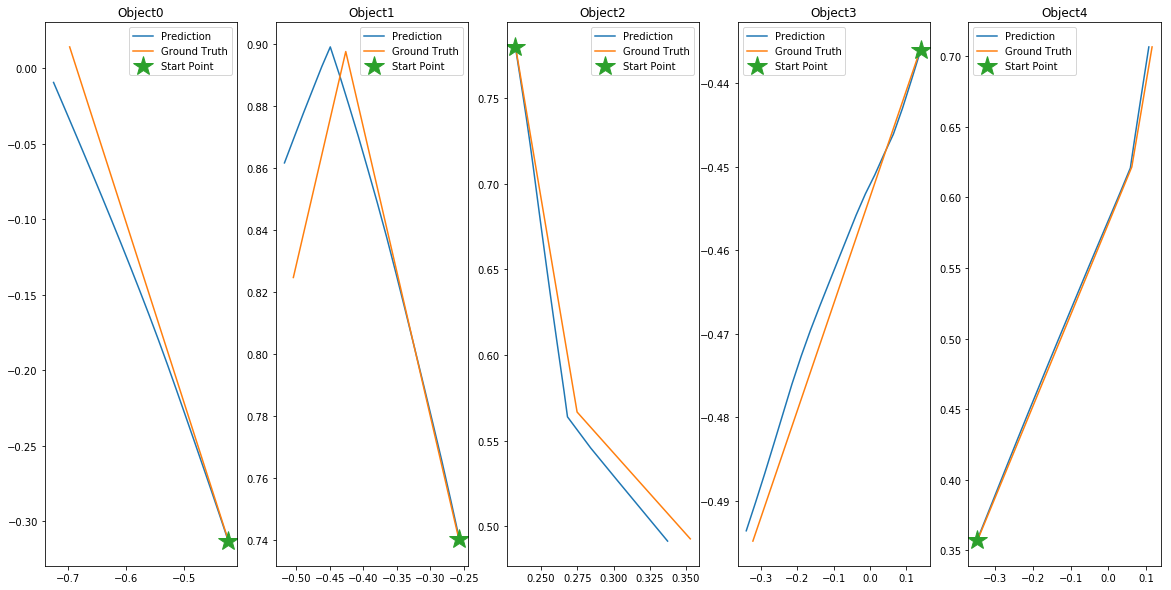

In [28]:
plt.figure(figsize=(20,10))
for i in range(Num_obj-1):
    plt.subplot(1,5,i+1)

    plt.plot(pos_x_list[i], pos_y_list[i], label='Prediction')
    plt.plot(true_pos_x_list[i], true_pos_y_list[i], label='Ground Truth')
    plt.plot(pos_x_list[i][0], pos_y_list[i][0], '*', markersize=20, label='Start Point')
    plt.title('Object' + str(i))
    plt.legend()